In [ ]:
# prompt: connect drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

# Load the Gini and GDP data, skipping the metadata rows at the beginning
gini_data = pd.read_csv('/content/drive/MyDrive/project/Kuznet/API_SI.POV.GINI_DS2_en_csv_v2_165.csv', skiprows=4)
gdp_data = pd.read_csv('/content/drive/MyDrive/project/Kuznet/API_NY.GDP.PCAP.CD_DS2_en_csv_v2_76.csv', skiprows=4)

# Drop columns that contain "Unnamed" (these are extra columns caused by incorrect parsing)
gini_data = gini_data.loc[:, ~gini_data.columns.str.contains('^Unnamed')]
gdp_data = gdp_data.loc[:, ~gdp_data.columns.str.contains('^Unnamed')]

# Drop unnecessary columns for both datasets
gini_data = gini_data.drop(columns=['Country Code', 'Indicator Name', 'Indicator Code'], errors='ignore')
gdp_data = gdp_data.drop(columns=['Country Code', 'Indicator Name', 'Indicator Code'], errors='ignore')

# Melt the data into a long format for easier manipulation
gini_data = gini_data.melt(id_vars=['Country Name'], var_name='Year', value_name='Gini')
gdp_data = gdp_data.melt(id_vars=['Country Name'], var_name='Year', value_name='GDP_Nominal_Per_Capita')

# Rename 'Country Name' to 'Country' for consistency
gini_data.rename(columns={'Country Name': 'Country'}, inplace=True)
gdp_data.rename(columns={'Country Name': 'Country'}, inplace=True)

# Ensure 'Year' is numeric
gini_data['Year'] = pd.to_numeric(gini_data['Year'], errors='coerce')
gdp_data['Year'] = pd.to_numeric(gdp_data['Year'], errors='coerce')

# Merge the two datasets on Country and Year
data = pd.merge(gini_data, gdp_data, on=['Country', 'Year'])

# Remove rows where either Gini or GDP are missing
data = data.dropna(subset=['Gini', 'GDP_Nominal_Per_Capita'])

# Calculate the Kuznet ratio
data['Kuznet_Ratio'] = data['Gini'] / data['GDP_Nominal_Per_Capita']

# Get the most recent year available for each country
most_recent_data = data.loc[data.groupby('Country')['Year'].idxmax()]

# Filter out rows where Kuznet ratio is zero
most_recent_data = most_recent_data[most_recent_data['Kuznet_Ratio'] > 0]

# Sort the data by Kuznet ratio in descending order
sorted_data = most_recent_data[['Country', 'Year', 'Kuznet_Ratio']].sort_values(by='Kuznet_Ratio', ascending=False)

# Round Kuznet ratio to 6 decimal places
sorted_data['Kuznet_Ratio'] = sorted_data['Kuznet_Ratio'].round(6)

# Assign ranks based on the Kuznet Ratio
sorted_data['Rank'] = range(1, len(sorted_data) + 1)

# Print the Kuznet ratios with ranks, including the year
print("Rank  Country                          Year    Kuznet Ratio")
for index, row in sorted_data.iterrows():
    print(f"{row['Rank']:<5} {row['Country']:<35} {row['Year']:<6} {row['Kuznet_Ratio']}")

Rank  Country                          Year    Kuznet Ratio
1     Burundi                             2020   0.178565
2     Mozambique                          2019   0.0969
3     Congo, Dem. Rep.                    2020   0.088075
4     Central African Republic            2021   0.087352
5     Madagascar                          2012   0.08632
6     Turkmenistan                        1998   0.06906
7     Malawi                              2019   0.066278
8     Rwanda                              2016   0.059902
9     Ethiopia                            2015   0.056284
10    Chad                                2022   0.055678
11    Niger                               2021   0.054048
12    Gambia, The                         2020   0.053864
13    Uganda                              2019   0.051943
14    Liberia                             2016   0.049397
15    Guyana                              1998   0.047888
16    Sierra Leone                        2018   0.042203
17    Lesotho   

In [ ]:
# Save the sorted data to a CSV file
output_file = '/content/drive/MyDrive/project/Kuznet/kuznet_ratio_sorted_data.csv'
sorted_data[['Rank', 'Country', 'Year', 'Kuznet_Ratio']].to_csv(output_file, index=False)

print(f"CSV file saved to {output_file}")

CSV file saved to /content/drive/MyDrive/project/Kuznet/kuznet_ratio_sorted_data.csv


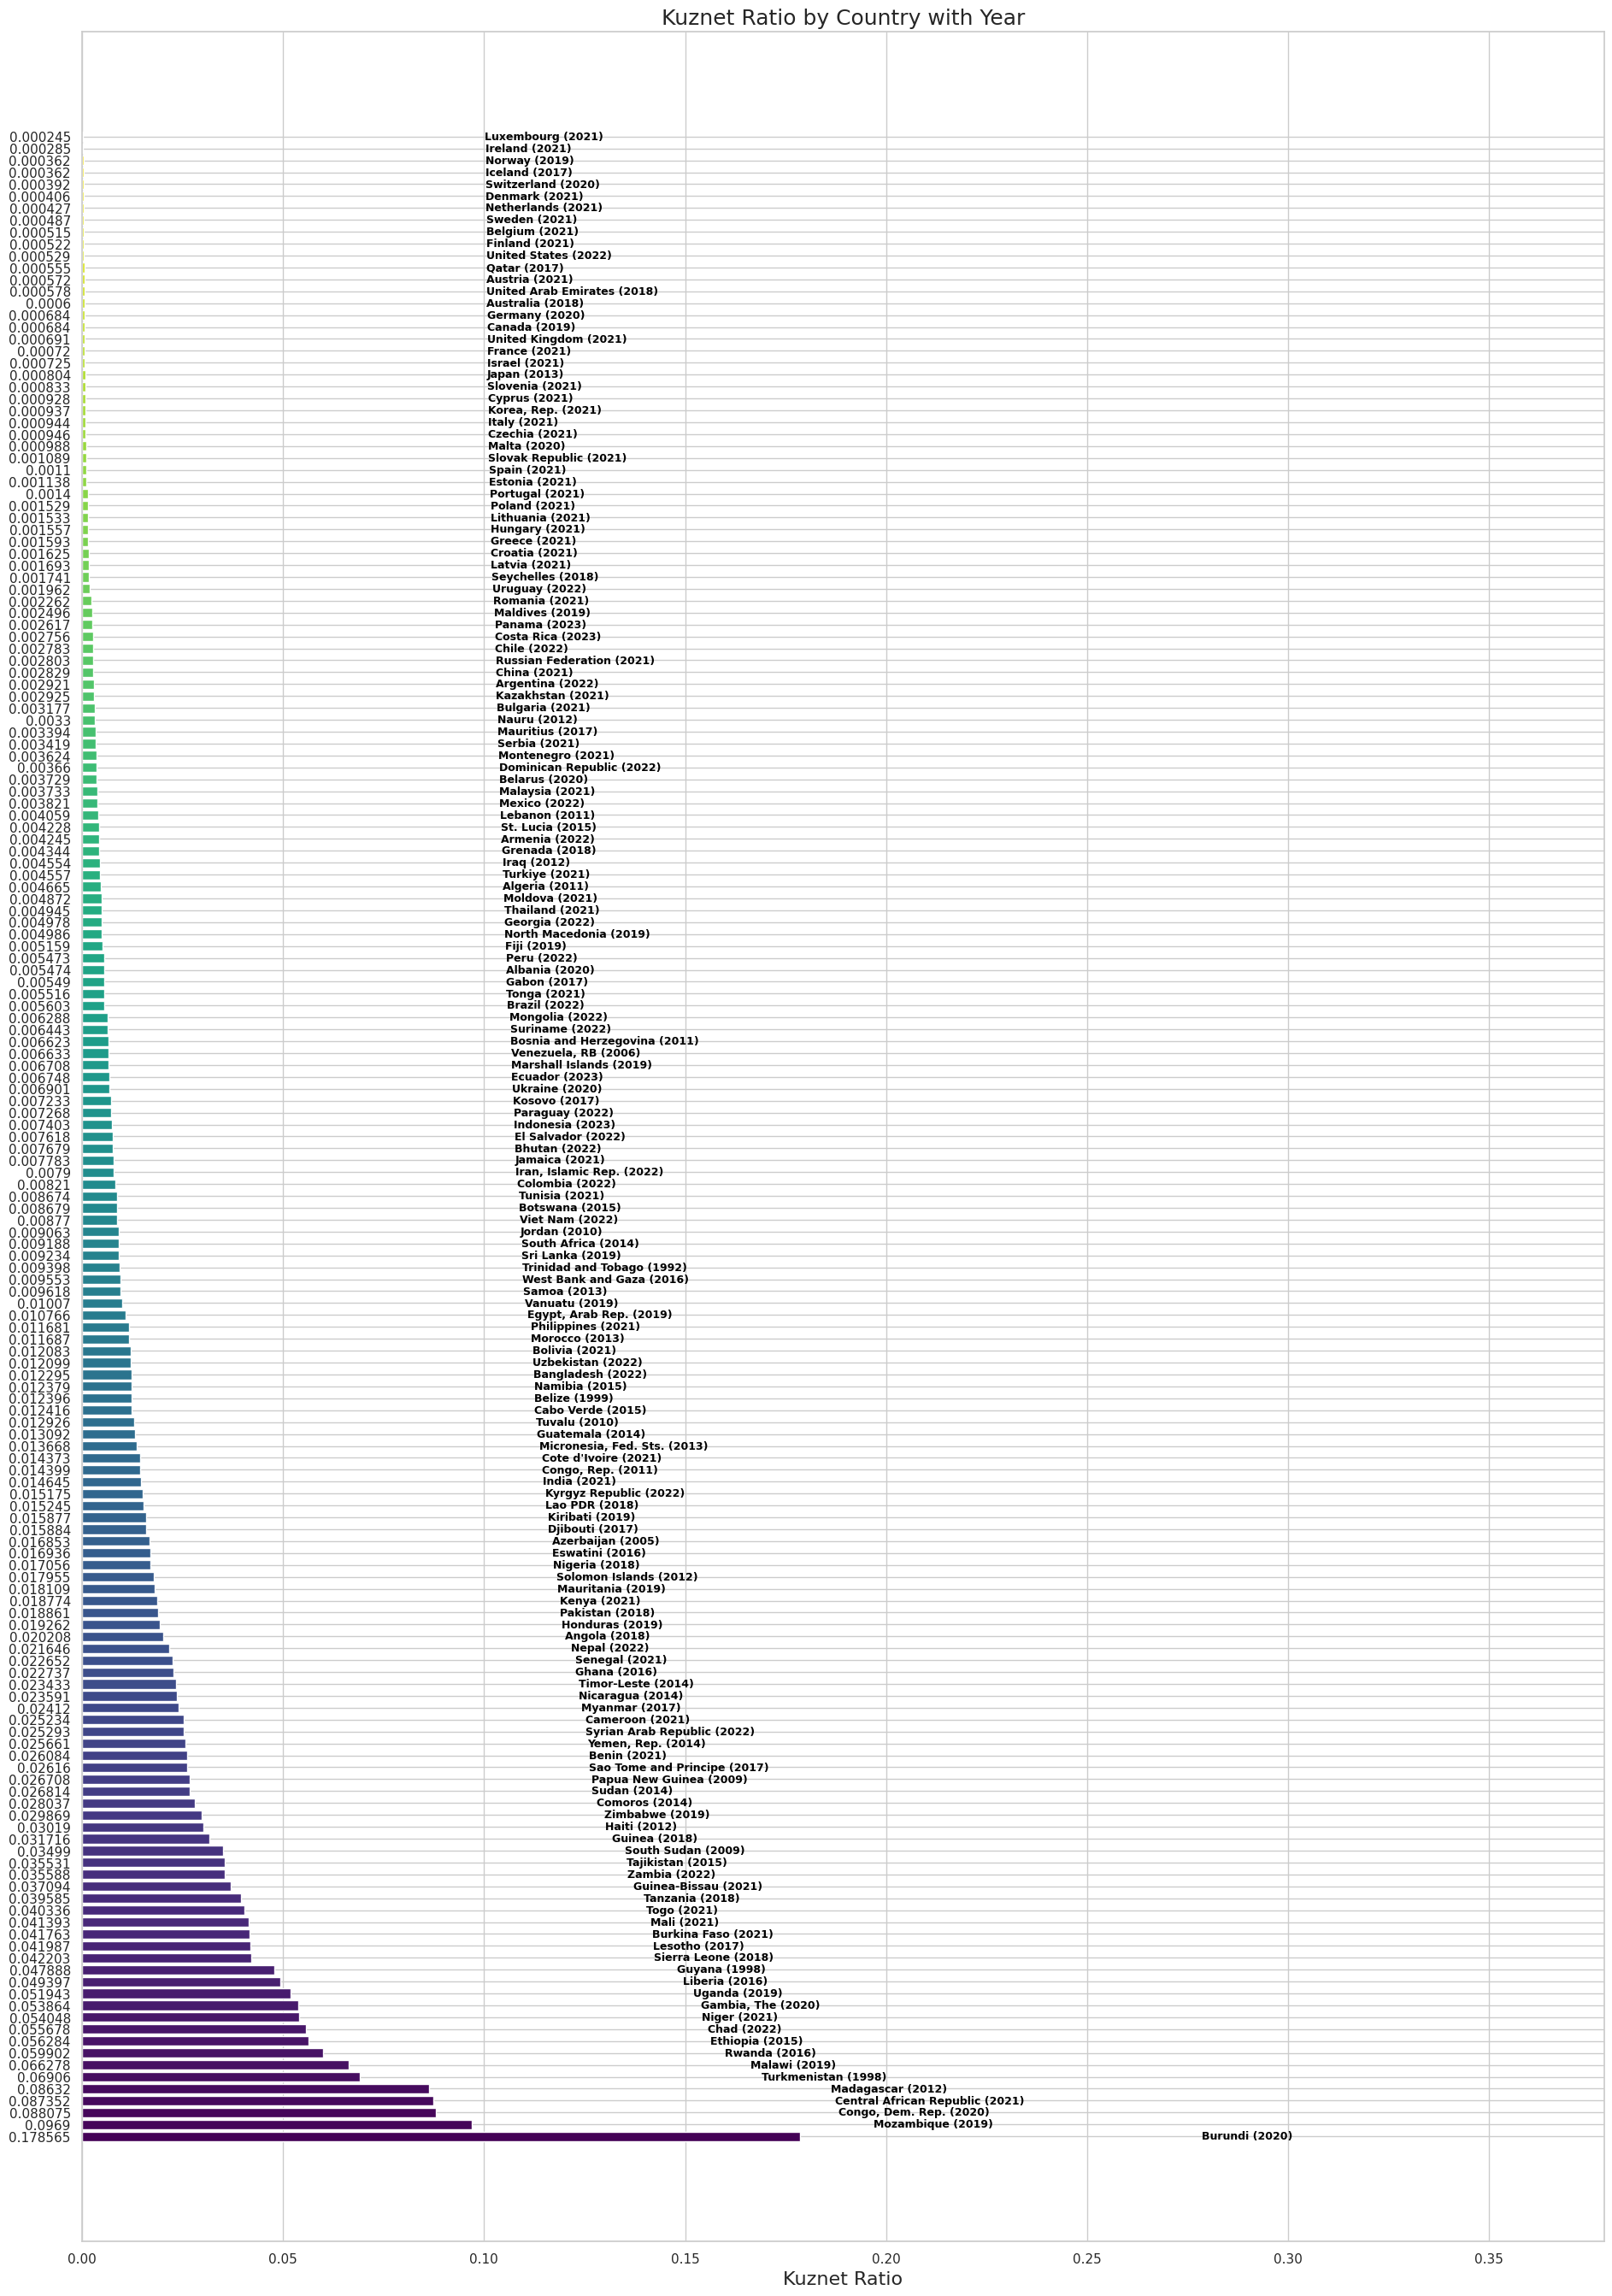

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the Seaborn style for better visuals
sns.set(style="whitegrid")

# Set up the plot with a larger figure size and more vertical space
plt.figure(figsize=(22, 30))  # Increase the height of the figure even more

# Plot horizontal bars for each country with the Kuznet ratio
bars = plt.barh(sorted_data['Country'], sorted_data['Kuznet_Ratio'], color=plt.cm.viridis(sorted_data['Rank'] / len(sorted_data)))

# Add text labels for each bar (country and year) with more spacing
for bar, index, row in zip(bars, sorted_data.index, sorted_data.itertuples()):
    # Move the label further to the right from the bar
    plt.text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, f"{row.Country} ({row.Year})",
             horizontalalignment='left', verticalalignment='center', fontsize=9, color='black', fontweight='bold')

# Set the y-axis values (Kuznet ratios)
plt.yticks(ticks=range(len(sorted_data)), labels=sorted_data['Kuznet_Ratio'].round(6))

# Set the x-axis label and title with larger font size
plt.xlabel("Kuznet Ratio", fontsize=16)
plt.title("Kuznet Ratio by Country with Year", fontsize=18)

# Display the grid for better readability
plt.grid(True, axis='x')

# Adjust the x-axis limit to make sure labels fit properly
plt.xlim(0, sorted_data['Kuznet_Ratio'].max() + 0.2)  # Allow more space for the labels

# Adjust the vertical layout to add more space between bars
plt.tight_layout(pad=10.0)  # Increased padding to make more space between bars

# Display the plot
plt.show()